In [43]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

import matplotlib.pyplot as plt
import seaborn as sns


In [44]:
try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    print("Please install the ucimlrepo with pip :)")

In [45]:
# fetch dataset 
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878) 
  
# data (as pandas dataframes) 
X = cirrhosis_patient_survival_prediction.data.features 
  
# metadata 
print(cirrhosis_patient_survival_prediction.metadata) 
  
# variable information 
print(cirrhosis_patient_survival_prediction.variables)

data = pd.DataFrame(X)

{'uci_id': 878, 'name': 'Cirrhosis Patient Survival Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1', 'data_url': 'https://archive.ics.uci.edu/static/public/878/data.csv', 'abstract': 'Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 418, 'num_features': 17, 'feature_types': ['Real', 'Categorical'], 'demographics': ['Age', 'Sex'], 'target_col': ['Status'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5R02G', 'creators': ['E. Dickson', 'P. Grambsch', 'T. Fleming', 'L. Fisher', 'A. Langworthy'], 'intro_paper': {'ID': 296, 'type'

In [5]:
print(data.head())

              Drug    Age Sex Ascites Hepatomegaly Spiders Edema  Bilirubin  \
0  D-penicillamine  21464   F       Y            Y       Y     Y       14.5   
1  D-penicillamine  20617   F       N            Y       Y     N        1.1   
2  D-penicillamine  25594   M       N            N       N     S        1.4   
3  D-penicillamine  19994   F       N            Y       Y     S        1.8   
4          Placebo  13918   F       N            Y       Y     N        3.4   

  Cholesterol  Albumin Copper  Alk_Phos    SGOT Tryglicerides Platelets  \
0         261     2.60    156    1718.0  137.95           172       190   
1         302     4.14     54    7394.8  113.52            88       221   
2         176     3.48    210     516.0   96.10            55       151   
3         244     2.54     64    6121.8   60.63            92       183   
4         279     3.53    143     671.0  113.15            72       136   

   Prothrombin  Stage  
0         12.2    4.0  
1         10.6    3.0  
2 

In [6]:
#data preparation and cleaning

data = data.replace('NaNN', np.nan)

cols = data.columns

na_per_col = {}

for col in cols:
    na_per_col[col] = data[col].isna().sum()


for key, value in na_per_col.items():
    print(key, value)

Drug 106
Age 0
Sex 0
Ascites 106
Hepatomegaly 106
Spiders 106
Edema 0
Bilirubin 0
Cholesterol 134
Albumin 0
Copper 108
Alk_Phos 106
SGOT 106
Tryglicerides 136
Platelets 11
Prothrombin 2
Stage 6


# Scaling the data

In [53]:
# Select only numeric columns from the data
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values in the numeric columns with their respective means
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())


In [54]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns for scaling
num_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Initialize the scaler
scaler = StandardScaler()

# Scale numerical columns only
data[num_cols] = scaler.fit_transform(data[num_cols])


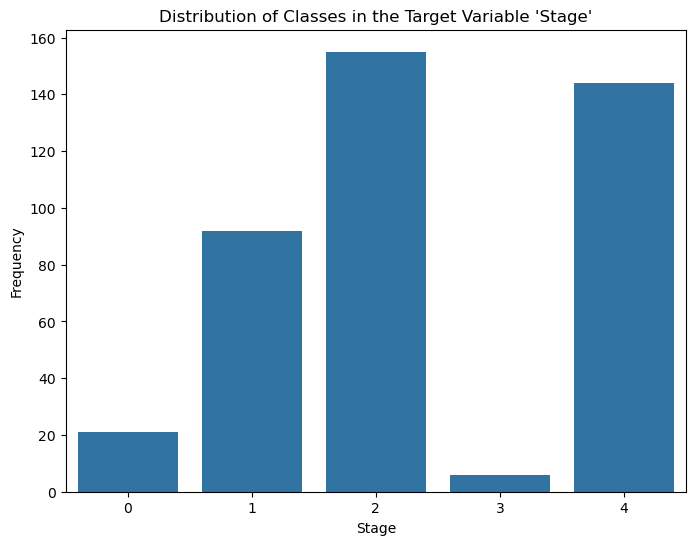

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable (Stage)
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Stage')
plt.title("Distribution of Classes in the Target Variable 'Stage'")
plt.xlabel("Stage")
plt.ylabel("Frequency")
plt.show()


# Baseline model

In [57]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Convert 'Stage' to categorical codes (integers representing each category)
data['Stage'] = data['Stage'].astype('category').cat.codes

# Proceed with the same steps
X = data.drop(columns=['Stage'])
y = data['Stage']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the baseline model
baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_train, y_train)

# Predict on the test set
y_pred = baseline_model.predict(X_test)

# Evaluate accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)
print("Baseline Model Accuracy:", baseline_accuracy)




Baseline Model Accuracy: 0.38095238095238093


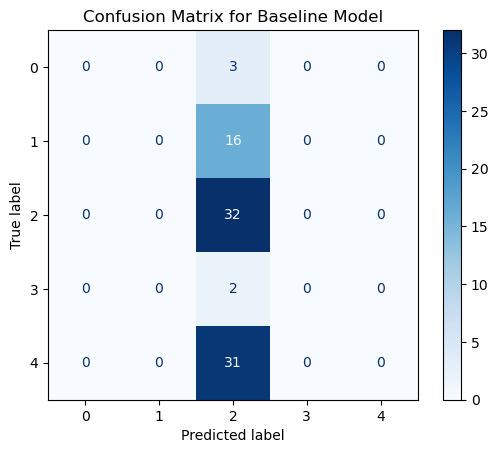

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Baseline Model")
plt.show()


# Logistic regression

Logistic Regression Accuracy: 0.34523809523809523


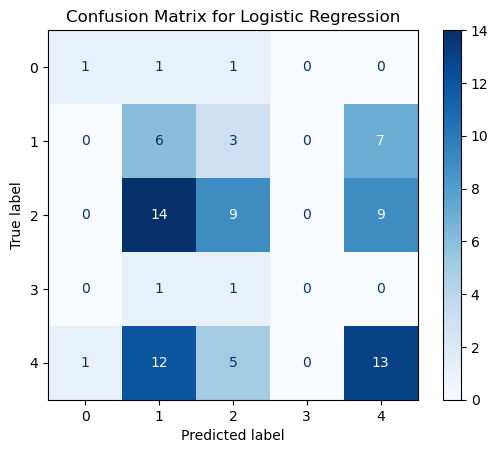

c:\Users\Lucija\anaconda3\envs\my-env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Cross-Validation Accuracy Scores: [0.47619048 0.21428571 0.54761905 0.52380952 0.4047619  0.38095238
 0.4047619  0.35714286 0.41463415 0.34146341]
Mean Cross-Validation Accuracy: 0.4065621370499419


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ensure 'Stage' is categorical and encode it if necessary
data['Stage'] = data['Stage'].astype('category').cat.codes

# Encode categorical features
X = pd.get_dummies(data.drop(columns=['Stage']), drop_first=True)  # Drop the original 'Stage' column

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define target variable
y = data['Stage']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred = log_reg.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Cross-validation accuracy
cv_scores = cross_val_score(log_reg, X, y, cv=10)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())
